# **Project 2**, APS1070 Fall 2022
**Anomaly Detection Algorithm using Gaussian Mixture Model**

**Deadline: Oct 27, 9 PM - 13 points**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Yuyang Shao
*   Student Number: 1002961636

### How to submit **(HTML + IPYNB)**

1. Download your notebook: `File -> Download .ipynb`

2. Click on the Files icon on the far left menu of Colab

3. Select & upload your `.ipynb` file you just downloaded, and then obtain its path (right click) (you might need to hit the Refresh button before your file shows up)


4. execute the following in a Colab cell:
```
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb
```

5. An HTML version of your notebook will appear in the files, so you can download it.

6. Submit **both** <font color='red'>`HTML` and `IPYNB`</font>  files on Quercus for grading.



Ref: https://stackoverflow.com/a/64487858 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**Part 1: Getting started [2 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807 **[0.1]**
* What features in the dataset are present aside from the 28 main features?  Time, Amount **[0.1]**
* Which column contains the targets? Class **[0.1]**
* What is the meaning of target values? 0 means non-fraud, 1 means fraud **[0.1]**

In [2]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (1).gz'

In [4]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [6]:
### YOUR CODE HERE ###
len(df)

284807

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
df.Class.unique()

array([0, 1])

It's important to know how many examples we have for each class when we work with a new dataset.

* What is the percentage of entries in the dataset for each class? {1: 0.001727485630620034, 0: 0.9982725143693799} **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case?This is imbalanced dataset. The data entries labelled non-fraud is much more than data entries labelled fraud **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? This imbalanced dataset tend to be severely skewed. This makes the model biased towards the non-fraudulent data. and could cause poor performance on the machine learning models and evaluation metrics. For KNN, if the model gets fit the imbalanced data like this, the space maybe filled with training data labelled non-fraud. If the model counts the nearest neighbours for prediction, it can barely make correct prediction about the fraud data points. So I don't think KNN is a suitable model here.   **[0.5]**
* What metrics should we use to evaluate a model in such cases? Recall and f1 score are good metrics to be used here since we care about TP and FN in fraud detection. TN and FP are not that important here. Recall = TP/(TP+FN) and f1 score is a comination of recall and precision.**[0.2]**


In [9]:
### YOUR CODE HERE ###
{1:len(df[df.Class==1]) / len(df), 0:len(df[df.Class==0]) / len(df)}

{1: 0.001727485630620034, 0: 0.9982725143693799}

Next, split the dataset into a training (65%), validation (20%) and testing set (15%). Set the random state to 40. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [10]:
import copy

In [11]:
### Split the data  ###
X = copy.deepcopy(df).drop('Class',axis=1)
y = df['Class']

X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size = 0.35,random_state=40)

X_val, X_test,y_val, y_test  = train_test_split(X_rem,y_rem,test_size = 3/7,random_state=40)
#X_train, X_val, X_test, y_train, y_val, y_test = 0, 0, 0, 0, 0, 0



In [12]:
len(X_train) / len(df)

0.6499980688676893

In [13]:
len(X_val) / len(df)

0.1999985955401377

In [14]:
len(X_test) / len(df)

0.15000333559217294

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

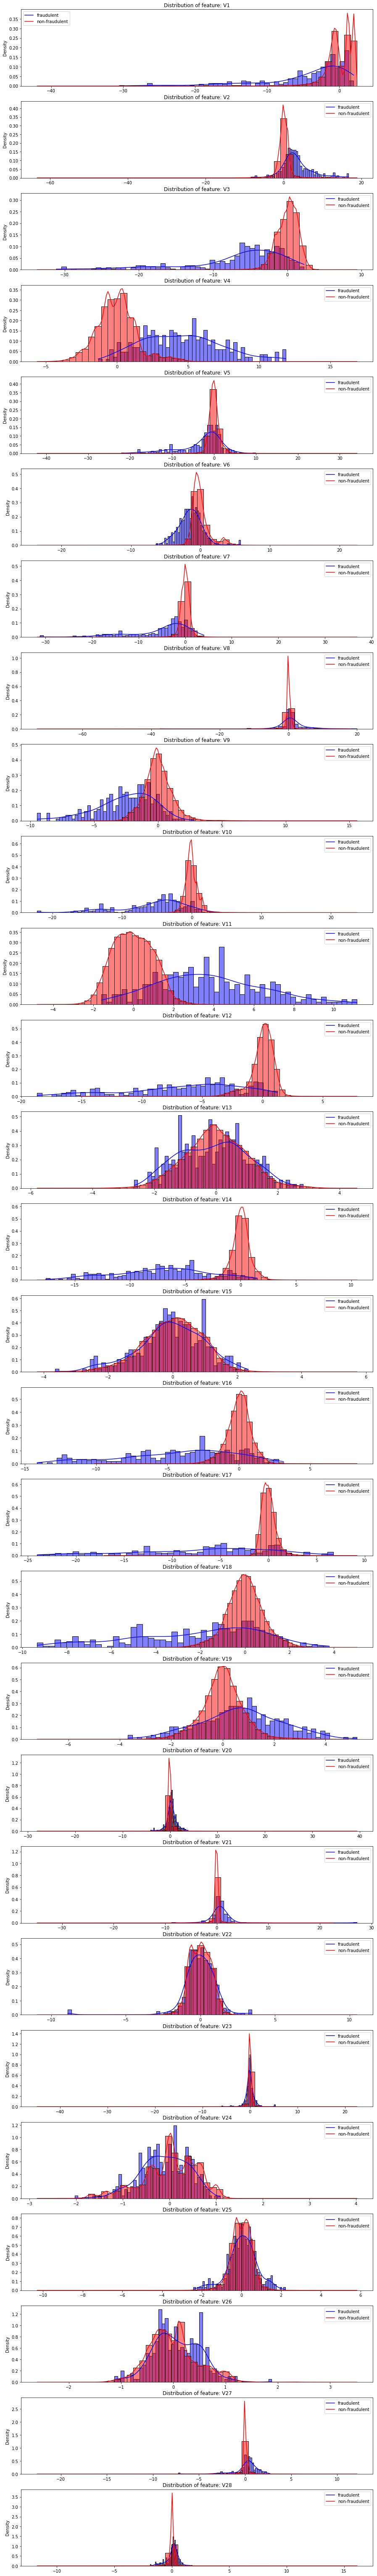

In [15]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

The graphs above show the distribution of density for fraudelent and non-fraudelent transactions of the 28 features. We are interested in the scope of values for fraud to happen and we can easily distinguish the scopes from the graph. For some of the features, like v16, v17, non-fraudulent data typically has a normal distribution with smaller scope of values while the fradulent data has a larger scope (base) of values and lower densities for each value. We can clearly see the 2 gaussians distributions for each features and we can focus on the scope of value that the fraud is likely to happen. For example, if we encounter a trasaction or data that have a v3 score that is very negative, we may flag it as fraudulent or validate it using other techniques. It saves time by narrowing the search space/scope of values.

## **Part 2: One Gaussian model with Single feature: [2 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. **[0.3]**
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  7. Report Precision, Recall and F1 score on both training and validation set in a table using the threshold you found in previous step. 
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.3]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian **only on non-fraudulent transactions in the training set** in step 1 (instead of all the transactions).
 3. Compare your results from parts 2a and 2b in a table (for both training and validation set). **[0.2]**
 4. Are these results different or similar? Why?**[0.5]**


In [16]:
### YOUR CODE HERE ###
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score

In [17]:
(X_train.iloc[:,1:29]).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
48736,0.979714,-0.117442,0.724345,1.220273,-0.706656,-0.601687,-0.012361,-0.164556,0.165637,-0.102820,...,-0.613589,0.174449,0.214348,0.452495,-0.199085,0.415293,0.522355,-0.311573,0.027772,0.053843
18318,0.881024,-0.413042,-0.357916,0.824474,-0.416866,-1.199597,0.658726,-0.364206,-0.078195,-0.073388,...,-0.175868,0.266511,0.142542,-0.065062,-0.316372,0.421493,0.603989,0.455355,-0.106472,0.036155
124471,-0.930149,0.291873,2.363718,-0.995319,-0.610913,-0.124068,1.563057,-0.485541,0.039959,-0.573449,...,-0.985949,0.061273,-0.192818,-0.326398,0.003109,0.416542,-0.140256,0.653770,-0.428585,-0.417909
269480,-0.569110,0.838594,2.180028,-0.367731,-0.062891,-0.323138,0.600888,-0.091194,0.442461,-0.561563,...,0.644125,0.180389,-0.214514,-0.292508,-0.309341,-0.075548,0.312511,-0.666343,0.191996,-0.080854
68108,-0.634695,1.010158,1.838947,1.196339,0.405008,0.310008,1.233778,-0.569650,-0.131414,0.352229,...,0.801395,0.104673,-0.077572,0.329556,-0.342727,0.134032,0.062678,-0.288092,-0.546651,-0.330850


In [18]:
df_AUC = pd.DataFrame(columns=['V_number','AUC_train_A','AUC_val_A','F1_A'],index = [i for i in range(1,29)])

In [19]:
for i in range(1,29):
  gm = GaussianMixture(n_components=1, random_state=40).fit(X_train.iloc[:,i].values.reshape(-1,1))
  p_gm = gm.score_samples(X_train.iloc[:,i].values.reshape(-1,1))
  #print ("AUC of Gaussian Mixture" , format(roc_auc_score(y_train.reshape(-1,1), 1-p_gm)  , ".3f")  )
  df_AUC.iloc[i-1,0] = i
  df_AUC.iloc[i-1,1] = roc_auc_score(y_train, -1*p_gm) # or -1*p_gm

  p_gm = gm.score_samples(X_val.iloc[:,i].values.reshape(-1,1))
  #print ("AUC of Gaussian Mixture" , format(roc_auc_score(y_val.reshape(-1,1), 1-p_gm)  , ".3f")  )
  df_AUC.iloc[i-1,2] = roc_auc_score(y_val, -1*p_gm)

In [20]:
df_AUC = df_AUC.sort_values(by = 'AUC_val_A', ascending = False).head(3)
df_AUC

,V_number,AUC_train_A,AUC_val_A,F1_A
14,14,0.954023,0.958037,NaN
17,17,0.927781,0.951067,NaN
10,10,0.913807,0.945576,NaN


Make a prediction based on a model's scores: If the score_samples is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using sklearn.metrics.f1_score.

In [21]:
# Since we include Time column, we can access v columns without adding -1 to the index.
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
48736,43761.0,0.979714,-0.117442,0.724345,1.220273,-0.706656,-0.601687,-0.012361,-0.164556,0.165637,...,0.174449,0.214348,0.452495,-0.199085,0.415293,0.522355,-0.311573,0.027772,0.053843,123.61
18318,29382.0,0.881024,-0.413042,-0.357916,0.824474,-0.416866,-1.199597,0.658726,-0.364206,-0.078195,...,0.266511,0.142542,-0.065062,-0.316372,0.421493,0.603989,0.455355,-0.106472,0.036155,218.60
124471,77300.0,-0.930149,0.291873,2.363718,-0.995319,-0.610913,-0.124068,1.563057,-0.485541,0.039959,...,0.061273,-0.192818,-0.326398,0.003109,0.416542,-0.140256,0.653770,-0.428585,-0.417909,182.52
269480,163666.0,-0.569110,0.838594,2.180028,-0.367731,-0.062891,-0.323138,0.600888,-0.091194,0.442461,...,0.180389,-0.214514,-0.292508,-0.309341,-0.075548,0.312511,-0.666343,0.191996,-0.080854,1.00
68108,52836.0,-0.634695,1.010158,1.838947,1.196339,0.405008,0.310008,1.233778,-0.569650,-0.131414,...,0.104673,-0.077572,0.329556,-0.342727,0.134032,0.062678,-0.288092,-0.546651,-0.330850,50.00


In [22]:
from scipy import stats

In [23]:
df_metrics = pd.DataFrame(columns = ['v_number','dataset','precision','recall','f1_score','AUC'])

In [24]:
# A fast way is to go through thresholds from (mean of score_samples) +- 2 std. 
# This is much better than a brute forth search.

In [25]:
#FIRST FEATURE V14
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train.iloc[:,14].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,14].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,14].values.reshape(-1,1))
 # if roc_auc_score(y_val.reshape(-1,1), 1-p_gm) < i
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-201.22202828248146, -0.877954354239072), mean=-1.3768424864560425, variance=7.1239657489924975, skewness=-39.90619545795707, kurtosis=2258.9127856625255)

The test range for threshold is from the min value to the mean value - 2*sd. The potential threshold value grows by a factor of 0.95 each iteration to avoid checking every possible value, which takes a long time.

In [26]:
threshold = -200
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -8:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[0,3] = best_f1

The best threshhold is  -19.88805139741844


In [27]:
df_metrics.columns

Index(['v_number', 'dataset', 'precision', 'recall', 'f1_score', 'AUC'], dtype='object')

In [28]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[0,'v_number'] = 14
df_metrics.loc[0,'dataset'] = 'val'
df_metrics.loc[0,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'AUC'] = roc_auc_score(y_val, -1*p_gm)
prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[1,'v_number'] = 14
df_metrics.loc[1,'dataset'] = 'train'
df_metrics.loc[1,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.6951219512195121,     recall is 0.59375, f1 score is 0.6404494382022472
training precision is 0.6282894736842105,     recall is 0.5913312693498453, f1 score is 0.6092503987240829


In [29]:
df_metrics

,v_number,dataset,precision,recall,f1_score,AUC
0,14,val,0.695122,0.59375,0.640449,0.958037
1,14,train,0.628289,0.591331,0.60925,0.954023


In [30]:
#SECOND FEATURE V10
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train.iloc[:,10].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,10].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,10].values.reshape(-1,1))
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-256.88911763683586, -1.002214929069638), mean=-1.5115112080987045, variance=10.60021072800009, skewness=-36.11268876151206, kurtosis=2164.9707739836654)

In [31]:
threshold = -256
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -8:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[1,3] = best_f1

The best threshhold is  -52.200147390922325


In [32]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[2,'v_number'] = 10
df_metrics.loc[2,'dataset'] = 'val'
df_metrics.loc[2,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'AUC'] = roc_auc_score(y_val, -1*p_gm)
prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[3,'v_number'] = 10
df_metrics.loc[3,'dataset'] = 'train'
df_metrics.loc[3,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.35294117647058826,     recall is 0.1875, f1 score is 0.24489795918367344
training precision is 0.417910447761194,     recall is 0.17337461300309598, f1 score is 0.2450765864332604


In [33]:
#THIRD FEATURE V17
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train.iloc[:,17].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,17].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,17].values.reshape(-1,1))
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-438.8729834771688, -0.7564876301739907), mean=-1.256095132246079, variance=24.869889328070933, skewness=-53.14391444422615, kurtosis=3536.661762133577)

In [34]:
threshold = -438
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -11:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[2,3] = best_f1

The best threshhold is  -21.240602059247323


In [35]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[4,'v_number'] = 17
df_metrics.loc[4,'dataset'] = 'val'
df_metrics.loc[4,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'AUC'] = roc_auc_score(y_val, -1*p_gm)
prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[5,'v_number'] = 17
df_metrics.loc[5,'dataset'] = 'train'
df_metrics.loc[5,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.7397260273972602,     recall is 0.5625, f1 score is 0.6390532544378699
training precision is 0.6546184738955824,     recall is 0.5046439628482973, f1 score is 0.5699300699300699


In [36]:
df_AUC

,V_number,AUC_train_A,AUC_val_A,F1_A
14,14,0.954023,0.958037,0.640449
17,17,0.927781,0.951067,0.244898
10,10,0.913807,0.945576,0.639053


In [37]:
df_AUC_tmp = copy.deepcopy(df_AUC)

In [38]:
df_metrics

,v_number,dataset,precision,recall,f1_score,AUC
0,14,val,0.695122,0.59375,0.640449,0.958037
1,14,train,0.628289,0.591331,0.60925,0.954023
2,10,val,0.352941,0.1875,0.244898,0.945576
3,10,train,0.41791,0.173375,0.245077,0.913807
4,17,val,0.739726,0.5625,0.639053,0.951067
5,17,train,0.654618,0.504644,0.56993,0.927781


In [39]:
df_metrics_tmp = copy.deepcopy(df_metrics)

I essentially check the threshold values from the minimum score to the score that is 2 standard deviation from the mean. Each time the threshold gorws by a factor of 0.95(we check threshold from large negative to small negative numbers. eg. -400 to -3. So the factor is < 1 not > 1). If the threshold grows by a factor for each iteration, then no matter how small the logarithmic base， the running time of the loop for determining the optimal threshold is always O(log(n)). For every possible threshold, I need to see if each score in the score list is lower than the threshold. This is a 2 level loop structure. 
Going over the score for each sample takes O(n) and going over the possible threshold values takes O(log(n)). So it is O(nlog(n)) in total.

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian **only on non-fraudulent transactions in the training set** in step 1 (instead of all the transactions).
 3. Compare your results from parts 2a and 2b in a table (for both training and validation set). **[0.2]**
 4. Are these results different or similar? Why?**[0.5]**

In [40]:
y_train[42784]

1

In [41]:
index = y_train[y_train==0].index
index

Int64Index([ 48736,  18318, 124471, 269480,  68108, 262680, 237984,  34563,
              7504, 260136,
            ...
            190133, 180667, 204755, 141367, 244554, 138911, 200211, 137031,
            142604, 114369],
           dtype='int64', length=184801)

In [42]:
X_train_nf = X_train.loc[index,:]

In [43]:
X_train_nf

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
48736,43761.0,0.979714,-0.117442,0.724345,1.220273,-0.706656,-0.601687,-0.012361,-0.164556,0.165637,...,0.174449,0.214348,0.452495,-0.199085,0.415293,0.522355,-0.311573,0.027772,0.053843,123.61
18318,29382.0,0.881024,-0.413042,-0.357916,0.824474,-0.416866,-1.199597,0.658726,-0.364206,-0.078195,...,0.266511,0.142542,-0.065062,-0.316372,0.421493,0.603989,0.455355,-0.106472,0.036155,218.60
124471,77300.0,-0.930149,0.291873,2.363718,-0.995319,-0.610913,-0.124068,1.563057,-0.485541,0.039959,...,0.061273,-0.192818,-0.326398,0.003109,0.416542,-0.140256,0.653770,-0.428585,-0.417909,182.52
269480,163666.0,-0.569110,0.838594,2.180028,-0.367731,-0.062891,-0.323138,0.600888,-0.091194,0.442461,...,0.180389,-0.214514,-0.292508,-0.309341,-0.075548,0.312511,-0.666343,0.191996,-0.080854,1.00
68108,52836.0,-0.634695,1.010158,1.838947,1.196339,0.405008,0.310008,1.233778,-0.569650,-0.131414,...,0.104673,-0.077572,0.329556,-0.342727,0.134032,0.062678,-0.288092,-0.546651,-0.330850,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138911,82912.0,-0.746363,1.427544,1.196475,1.213289,-0.187187,-0.431339,0.254315,0.428527,-0.883664,...,0.072226,0.241926,0.811914,-0.096571,0.427751,-0.203469,-0.191222,0.314414,0.146678,1.00
200211,133338.0,-0.836827,0.197551,1.425084,-0.814607,0.781293,1.564700,-0.067812,0.709666,0.456200,...,-0.035740,0.340147,1.293175,-0.119527,-1.408162,-0.373323,0.768922,0.398510,0.183082,22.29
137031,81988.0,0.942883,0.353067,0.671608,2.147001,0.668415,1.837514,-0.290516,0.632040,-1.050095,...,-0.248841,-0.071237,-0.173220,0.251591,-1.058023,-0.090554,-0.156453,0.061092,0.005493,9.91
142604,84819.0,-0.531536,0.854556,1.595593,0.477754,0.114464,-0.287914,1.748649,-0.644067,-0.317733,...,-0.111065,-0.467143,-0.978935,0.203441,0.333213,-0.328248,-0.956925,-0.443684,-0.466231,114.00


In [44]:
#FIRST FEATURE V14
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train_nf.iloc[:,14].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,14].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,14].values.reshape(-1,1))
 # if roc_auc_score(y_val.reshape(-1,1), 1-p_gm) < i
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-230.23321521396753, -0.8108310134082712), mean=-1.3814637673309182, variance=9.353270396612048, skewness=-39.86989989898698, kurtosis=2254.925702519906)

In [45]:
threshold = -200
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -8:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[0,3] = best_f1

The best threshhold is  -23.1964442600011


In [46]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[0,'v_number'] = 14
df_metrics.loc[0,'dataset'] = 'val'
df_metrics.loc[0,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[0,'AUC'] = roc_auc_score(y_val, -1*p_gm)
prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[1,'v_number'] = 14
df_metrics.loc[1,'dataset'] = 'train'
df_metrics.loc[1,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[1,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.7088607594936709,     recall is 0.5833333333333334, f1 score is 0.64
training precision is 0.6354515050167224,     recall is 0.5882352941176471, f1 score is 0.6109324758842444


In [47]:
#SECOND FEATURE V10
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train_nf.iloc[:,10].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,10].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,10].values.reshape(-1,1))
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-277.9985615759581, -0.9628996880226625), mean=-1.5138664053138151, variance=12.39536443268867, skewness=-36.20563923510623, kurtosis=2174.796863974453)

In [48]:
threshold = -256
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -8:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[1,3] = best_f1

The best threshhold is  -57.839498494096766


In [49]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[2,'v_number'] = 10
df_metrics.loc[2,'dataset'] = 'val'
df_metrics.loc[2,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[2,'AUC'] = roc_auc_score(y_val, -1*p_gm)

prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[3,'v_number'] = 10
df_metrics.loc[3,'dataset'] = 'train'
df_metrics.loc[3,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[3,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.375,     recall is 0.1875, f1 score is 0.25
training precision is 0.44,     recall is 0.17027863777089783, f1 score is 0.24553571428571427


In [50]:
#THIRD FEATURE V17
gm = GaussianMixture(n_components=1, random_state=40).fit(X_train_nf.iloc[:,17].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train.iloc[:,17].values.reshape(-1,1))
p_gm = gm.score_samples(X_val.iloc[:,17].values.reshape(-1,1))
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-564.2912952965831, -0.6309586848750903), mean=-1.2732595429711648, variance=41.17577648365609, skewness=-53.15355210384348, kurtosis=3536.4911252998613)

In [51]:
threshold = -438
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -11:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
df_AUC.iloc[2,3] = best_f1

The best threshhold is  -27.45040751181251


In [52]:
prediction = []
for j in range(0,len(p_gm)):
  if p_gm[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"validation precision is {precision_score(y_true=y_val,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_val,y_pred=prediction)}, f1 score is {f1_score(y_true=y_val,y_pred=prediction)}")
df_metrics.loc[4,'v_number'] = 17
df_metrics.loc[4,'dataset'] = 'val'
df_metrics.loc[4,'precision'] = precision_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'recall'] = recall_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'f1_score'] = f1_score(y_true=y_val,y_pred=prediction)
df_metrics.loc[4,'AUC'] = roc_auc_score(y_val, -1*p_gm)
prediction = []

for j in range(0,len(p_gm_train)):
  if p_gm_train[j] < best_thresh :
    prediction.append(1)
  else:
    prediction.append(0)

print(f"training precision is {precision_score(y_true=y_train,y_pred=prediction)}, \
    recall is {recall_score(y_true=y_train,y_pred=prediction)}, f1 score is {f1_score(y_true=y_train,y_pred=prediction)}")
df_metrics.loc[5,'v_number'] = 17
df_metrics.loc[5,'dataset'] = 'train'
df_metrics.loc[5,'precision'] = precision_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'recall'] = recall_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'f1_score'] = f1_score(y_true=y_train,y_pred=prediction)
df_metrics.loc[5,'AUC'] = roc_auc_score(y_train, -1*p_gm_train)

validation precision is 0.7397260273972602,     recall is 0.5625, f1 score is 0.6390532544378699
training precision is 0.659919028340081,     recall is 0.5046439628482973, f1 score is 0.5719298245614036


In [53]:
df_AUC

,V_number,AUC_train_A,AUC_val_A,F1_A
14,14,0.954023,0.958037,0.64
17,17,0.927781,0.951067,0.25
10,10,0.913807,0.945576,0.639053


In [54]:
df_metrics

,v_number,dataset,precision,recall,f1_score,AUC
0,14,val,0.708861,0.583333,0.64,0.957865
1,14,train,0.635452,0.588235,0.610932,0.954344
2,10,val,0.375,0.1875,0.25,0.945692
3,10,train,0.44,0.170279,0.245536,0.913869
4,17,val,0.739726,0.5625,0.639053,0.951155
5,17,train,0.659919,0.504644,0.57193,0.927021


In [55]:
# compare to the results in part A

In [56]:
df_AUC_tmp

,V_number,AUC_train_A,AUC_val_A,F1_A
14,14,0.954023,0.958037,0.640449
17,17,0.927781,0.951067,0.244898
10,10,0.913807,0.945576,0.639053


In [57]:
df_metrics_tmp

,v_number,dataset,precision,recall,f1_score,AUC
0,14,val,0.695122,0.59375,0.640449,0.958037
1,14,train,0.628289,0.591331,0.60925,0.954023
2,10,val,0.352941,0.1875,0.244898,0.945576
3,10,train,0.41791,0.173375,0.245077,0.913807
4,17,val,0.739726,0.5625,0.639053,0.951067
5,17,train,0.654618,0.504644,0.56993,0.927781


The results are similar because our data is imbalanced and the fraudulent data is only a small proportion of the whole training data. The model can barely learn anything useful from it. Our model may get very good TN predictions but not the case for TP predictions.

## **Part 3: One Gaussian model with multiple features: [2 Marks]**
This part is similar to Part 2, but here we will pick multiple features and set the number of components **visually**.

 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features of the training set on a figure (f1 on the x-axis and f2 on the y-axis). **[0.25]**
 3. On the scatter plot color the training set based on their class (non-fraudulents blue and fraudulents red). **[0.25]**
 4. Based on your plots decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). **[0.25]**
 5. Fit your Gaussian model on the training set (all samples). 
 6. Compute AUC on both training and validation sets **[0.25]**
 7. Pick 3 new pair of features and repeat steps 2 to 6. **[0.5]**
 8. Pick the set with the highest AUC on the validation set (out of the four sets that you tried.)
 9. Find a threshold to maximize your F1 Score on the validation set.**[0.25]**
 10. Plot two seperate figures (one for the training data and one for the validation data) similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in tutorial) **[0.25]**




In [58]:
### YOUR CODE HERE ###

In [59]:
index = y_train[y_train==1].index
X_train_f = X_train.loc[index,:]
len(X_train_f)

323

In [60]:
colors = {0:'blue', 1:'red'}

First Model

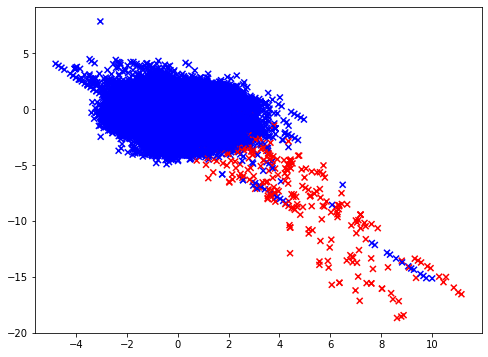

In [61]:
# first we pick v11 and v12
plt.figure(figsize=(8,6))
plt.scatter(X_train.iloc[:,11],X_train.iloc[:,12],marker="x",c = y_train.map(colors))
plt.show()

Clearly, 2 components are shown on the plot and give the best AUC scores.

In [62]:
gm = GaussianMixture(n_components=2, random_state=40).fit(X_train.iloc[:,[11,12]])

In [63]:
p_gm_train = gm.score_samples(X_train.iloc[:,[11,12]])
print ("AUC of train score" , format(roc_auc_score(y_train, -1*p_gm_train)  , ".3f")  )

p_gm = gm.score_samples(X_val.iloc[:,[11,12]])
print ("AUC of validation score" , format(roc_auc_score(y_val, -1*p_gm)  , ".3f")  )

AUC of train score 0.934
AUC of validation score 0.950


Second Model

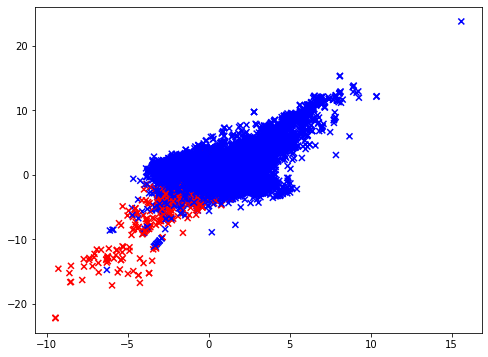

In [64]:
# we pick v9 and v10
plt.figure(figsize=(8,6))
plt.scatter(X_train.iloc[:,9],X_train.iloc[:,10],marker="x",c = y_train.map(colors))
plt.show()

2 gaussian components are needed for the best AUC scores

In [65]:
gm = GaussianMixture(n_components=2, random_state=40).fit(X_train.iloc[:,[9,10]])

In [66]:
p_gm_train = gm.score_samples(X_train.iloc[:,[9,10]])
print ("AUC of train score" , format(roc_auc_score(y_train, -1*p_gm_train)  , ".3f")  )
p_gm = gm.score_samples(X_val.iloc[:,[9,10]])
print ("AUC of validation score" , format(roc_auc_score(y_val, -1*p_gm)  , ".3f")  )

AUC of train score 0.917
AUC of validation score 0.951


Third Model

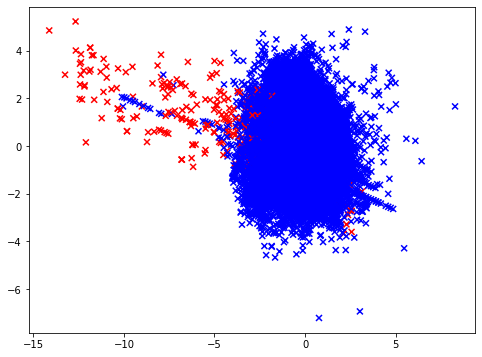

In [67]:
# we pick v16 and v19
plt.figure(figsize=(8,6))
plt.scatter(X_train.iloc[:,16],X_train.iloc[:,19],marker="x",c = y_train.map(colors))
plt.show()

2 components turns out to give the best AUC

In [68]:
gm = GaussianMixture(n_components=2, random_state=40).fit(X_train.iloc[:,[16,19]])

In [69]:
p_gm_train = gm.score_samples(X_train.iloc[:,[16,19]])
print ("AUC of train score" , format(roc_auc_score(y_train, -1*p_gm_train)  , ".3f")  )
p_gm = gm.score_samples(X_val.iloc[:,[16,19]])
print ("AUC of validation score" , format(roc_auc_score(y_val, -1*p_gm)  , ".3f")  )

AUC of train score 0.913
AUC of validation score 0.933


Fourth Model

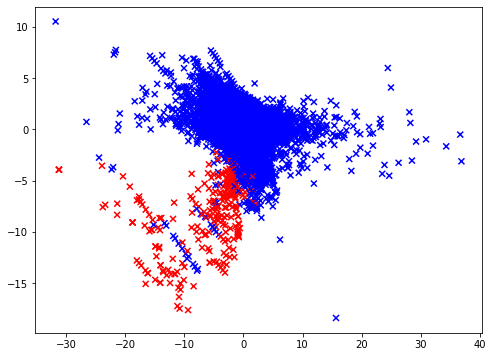

In [70]:
# we pick v7 and v14
plt.figure(figsize=(8,6))
plt.scatter(X_train.iloc[:,7],X_train.iloc[:,14],marker="x",c = y_train.map(colors))
plt.show()

It is clear that 2 components are shown in the plot. It also gives the highest AUC scores.

In [71]:
gm = GaussianMixture(n_components=2, random_state=40).fit(X_train.iloc[:,[7,14]])

In [72]:
p_gm_train = gm.score_samples(X_train.iloc[:,[7,14]])
print ("AUC of train score" , format(roc_auc_score(y_train, -1*p_gm_train)  , ".3f")  )
p_gm = gm.score_samples(X_val.iloc[:,[7,14]])
print ("AUC of validation score" , format(roc_auc_score(y_val, -1*p_gm)  , ".3f")  )

AUC of train score 0.962
AUC of validation score 0.965


So the best validation AUC score comes from the fourth model

In [73]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-617.6897655450059, -1.3129104973556638), mean=-2.6133547875533556, variance=10.049903589006949, skewness=-130.1326309756359, kurtosis=24909.6368932366)

In [74]:
threshold = -267
best_thresh = 0
best_f1 = 0
prediction = []
while threshold <= -7:
  for j in range(0,len(p_gm)):
    if p_gm[j] < threshold :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)
    best_thresh = threshold
  #print(f1_score(y_val, np.array(prediction)))
  threshold *= 0.95
  prediction = []
print("The best threshhold is ", best_thresh)
print("The best f1_score", best_f1.round(2))

The best threshhold is  -12.948038241595969
The best f1_score 0.51


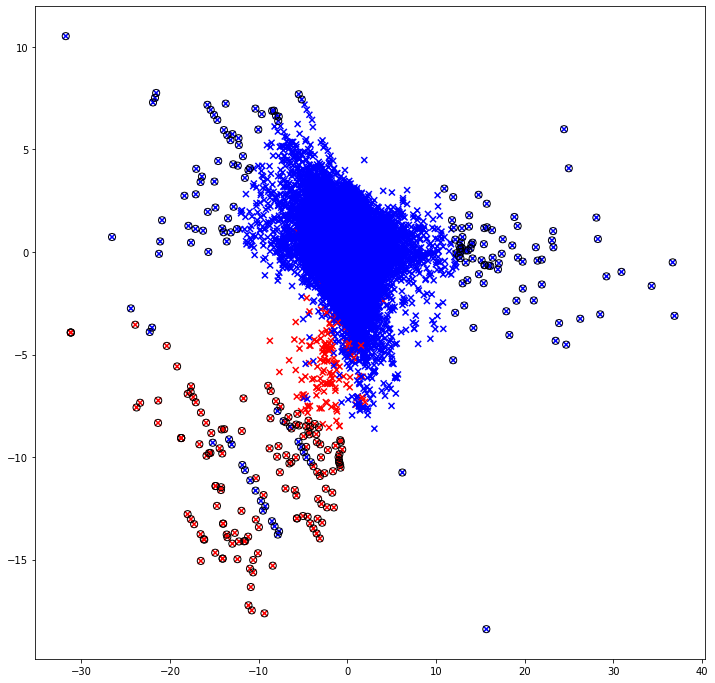

In [75]:
# outlier for training set
plt.figure(figsize=(12,12))
plt.scatter(X_train.iloc[:,7],X_train.iloc[:,14],marker="x",c=y_train.map(colors));
outliers = np.nonzero(p_gm_train<best_thresh)[0]
plt.scatter(X_train.iloc[outliers,7],X_train.iloc[outliers,14],marker="o",facecolor="none",edgecolor="black",s=50);

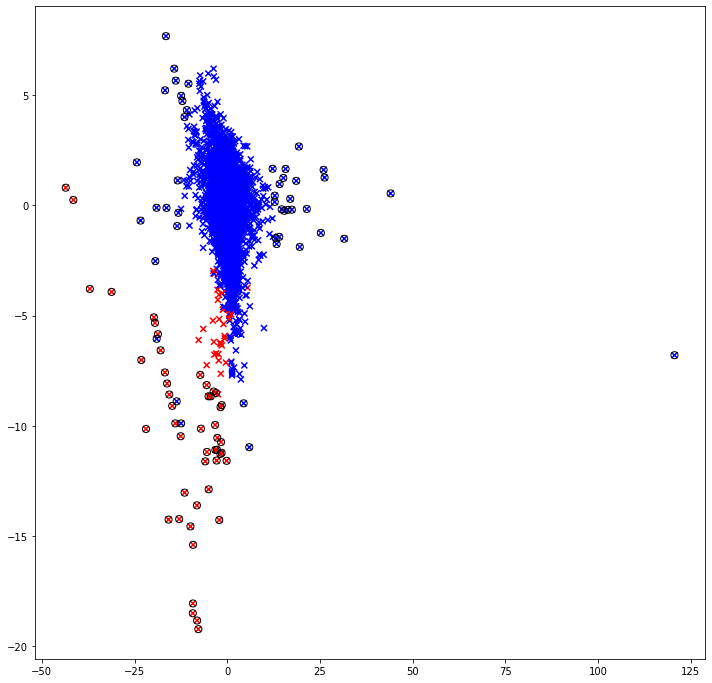

In [76]:
# outlier for validation set
plt.figure(figsize=(12,12))
plt.scatter(X_val.iloc[:,7],X_val.iloc[:,14],marker="x",c=y_val.map(colors));
outliers = np.nonzero(p_gm<best_thresh)[0]
plt.scatter(X_val.iloc[outliers,7],X_val.iloc[outliers,14],marker="o",facecolor="none",edgecolor="black",s=50);

## **Part 4:  Two Gaussian model with single feature. [3 Marks]**
Now we will use two separate distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.5]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.5]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.5]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.5]**
  5. Repeat the steps above for all the features. What is the best F1 Score, Precision and Recall that you get for training and validation? Which feature and what c? Show your results in a table. **[0.5]**
  6. Can we report AUC for this model? Why? **[0.5]**

In [77]:
#X_train.iloc[:,[1,2]]

In [78]:
df_result = pd.DataFrame(columns=['dataset','F1','precision','recall','feature','c'])

In [79]:
### YOUR CODE HERE ###
window = np.linspace(1,20,191)
window = np.round(window,1)
best_c = 0
best_f1 = 0
best_precision = 0
best_recall = 0
best_feature = 0
#f1_list = []
#c_list = []
for i in range(1,29):
  G1 = GaussianMixture(n_components=1, random_state=0).fit(X_train_nf.iloc[:,i].values.reshape(-1,1))
  G2 = GaussianMixture(n_components=1, random_state=0).fit(X_train_f.iloc[:,i].values.reshape(-1,1))
  S1 = G1.score_samples(X_val.iloc[:,i].values.reshape(-1,1))
  S2 = G2.score_samples(X_val.iloc[:,i].values.reshape(-1,1))
  prediction = []
  for c in window:    
    for j in range(0,len(X_val)):
      if S1[j]<c*S2[j] :
        prediction.append(1)
      else:
        prediction.append(0)
    #print(f1_score(y_val, prediction))
    if f1_score(y_val, prediction) > best_f1 :
      best_f1 = f1_score(y_val, prediction)  
      best_precision = precision_score(y_val,prediction)
      best_recall = recall_score(y_val,prediction)  
      best_feature = i 
      best_c = c 
    prediction = []     
  #f1_list.append(best_f1)
  #c_list.append(best_c)



In [80]:
df_result.loc[0,'dataset'] = 'val'
df_result.loc[0,'F1'] = best_f1
df_result.loc[0,'precision'] = best_precision
df_result.loc[0,'recall'] = best_recall
df_result.loc[0,'feature'] = best_feature
df_result.loc[0,'c'] = best_c

In [81]:
df_result

,dataset,F1,precision,recall,feature,c
0,val,0.760736,0.925373,0.645833,12,5.4


In [82]:
window = np.linspace(1,20,191)
window = np.round(window,1)
best_c = 0
best_f1 = 0
best_precision = 0
best_recall = 0
best_feature = 0
#f1_list = []
#c_list = []
for i in range(1,29):
  G1 = GaussianMixture(n_components=1, random_state=0).fit(X_train_nf.iloc[:,i].values.reshape(-1,1))
  G2 = GaussianMixture(n_components=1, random_state=0).fit(X_train_f.iloc[:,i].values.reshape(-1,1))
  S1 = G1.score_samples(X_train.iloc[:,i].values.reshape(-1,1))
  S2 = G2.score_samples(X_train.iloc[:,i].values.reshape(-1,1))
  prediction = []
  for c in window:    
    for j in range(0,len(X_train)):
      if S1[j]<c*S2[j] :
        prediction.append(1)
      else:
        prediction.append(0)
    if f1_score(y_train, prediction) > best_f1 :
      best_f1 = f1_score(y_train, prediction)  
      best_precision = precision_score(y_train,prediction)
      best_recall = recall_score(y_train,prediction)  
      best_feature = i 
      best_c = c 
    prediction = []     


In [83]:
df_result.loc[1,'dataset'] = 'train'
df_result.loc[1,'F1'] = best_f1
df_result.loc[1,'precision'] = best_precision
df_result.loc[1,'recall'] = best_recall
df_result.loc[1,'feature'] = best_feature
df_result.loc[1,'c'] = best_c

In [84]:
df_result

,dataset,F1,precision,recall,feature,c
0,val,0.760736,0.925373,0.645833,12,5.4
1,train,0.673684,0.777328,0.594427,12,4.7


This model is a combination of 2 Gaussian mixture models. In previous part, we used the scores of the samples and the labels to find the AUC score using sklearn built in function. The computation of AUC is not straight forward here. Here we need to first manually compute TPR and FPR in 2 lists to plot the ROC curve. Then we need to calculate AUC using Simpson's Rule. 

## **Part 5: Multivariate and Mixture of Gaussians Distribution [3 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) .
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score, Precision and Recall (after tuning the threshold) for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[3]**


**HINT !**

You might want to try a two gaussian model, multiple features, single component for valid transaction and multiple components for fraudulent ones! Why does it make sense to have multiple components for the fraudulent transactions?

In [85]:
counter = 0

In [86]:
### YOUR CODE HERE ###
df_models = pd.DataFrame(columns=['description','AUC_train','F1_train','precision_train','recall_train','thresh_train','AUC_val','F1_val','precision_val','recall_val','thresh_val']\
                         ,index = [i for i in range(1,13)])

In [87]:
### YOUR CODE HERE ###
def analyze(fit_features,score_features,n_components,targets):
  if fit_features.ndim == 1:
    gm = GaussianMixture(n_components=n_components, random_state=0).fit(fit_features.reshape(-1,1))
    p_gm = gm.score_samples(score_features.reshape(-1,1))
  else:
    gm = GaussianMixture(n_components=n_components, random_state=0).fit(fit_features)
    p_gm = gm.score_samples(score_features)
  #print ("AUC of Gaussian Mixture" , format(roc_auc_score(y_val.reshape(-1,1), 1-p_gm)  , ".3f")  )
  auc_score =  roc_auc_score(targets, -1*p_gm)
  return p_gm,auc_score

def get_scores(p_gm,start_thresh,end_thresh,targets):
  best_thresh = 0
  best_f1 = 0
  best_precision = 0
  best_recall = 0
  prediction = []
  threshold = start_thresh
  while threshold <= end_thresh:
    for j in range(0,len(p_gm)):
      if p_gm[j] < threshold :
        prediction.append(1)
      else:
        prediction.append(0)
    if f1_score(targets, prediction) > best_f1 :
      best_f1 = f1_score(targets, prediction)
      best_precision = precision_score(targets, prediction)
      best_recall = recall_score(targets,prediction)
      best_thresh = threshold
    #print(f1_score(targets, np.array(prediction)))
    threshold *= 0.95
    prediction = []
  return best_f1,best_precision, best_recall, best_thresh

First Model

In [88]:
#first model
#using v12 and n_components = 1 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,12].values,X_train.iloc[:,12].values,1,y_train)
df_models.iloc[0,0] = "v12,1,training data"
df_models.iloc[0,1] = auc_score

In [89]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-175.89342607182806, -0.9177140530850814), mean=-1.417713551858627, variance=5.666313354311717, skewness=-38.70662014626953, kurtosis=1939.4502597762084)

In [90]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-175,-8,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [91]:
p_gm,auc_score = analyze(X_train.iloc[:,12].values,X_val.iloc[:,12].values,1,y_val)
df_models.iloc[counter,6] = auc_score

In [92]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-164.18181182608325, -0.9177140621229515), mean=-1.4172970714134272, variance=5.358684863342547, skewness=-42.292544080751384, kurtosis=2391.797416699571)

In [93]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-164,-8,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
counter+=1

Second Model

In [95]:
#second model
#using v12,v14 and n_components = 1 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14]].values,X_train.iloc[:,[12,14]].values,1,y_train)
df_models.iloc[counter,0] = "v12,v14,1,training data"
df_models.iloc[counter,1] = auc_score

In [96]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-305.26799424456607, -1.795656458169936), mean=-2.795654465456353, variance=21.29734554658404, skewness=-36.080390032213764, kurtosis=1665.216447984427)

In [97]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-305,-13,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [98]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14]].values,X_val.iloc[:,[12,14]].values,1,y_val)
df_models.iloc[counter,6] = auc_score

In [99]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-358.60529213952935, -1.795658594651314), mean=-2.7942058362414355, variance=22.170936272146587, skewness=-44.43341485696876, kurtosis=2649.4415947859375)

In [100]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-358,-13,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
counter+=1

Third Model

In [102]:
#third model
#using v12,v14 and n_components = 2 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14]].values,X_train.iloc[:,[12,14]].values,2,y_train)
df_models.iloc[counter,0] = "v12,v14,2,training data"
df_models.iloc[counter,1] = auc_score

In [103]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-95.26290573934547, -1.0831731403682094), mean=-2.4949604324599988, variance=3.7876626408489473, skewness=-13.570669622091536, kurtosis=428.035286124944)

In [104]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-95,-8,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [105]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14]].values,X_val.iloc[:,[12,14]].values,2,y_val)
df_models.iloc[counter,6] = auc_score

In [106]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-106.34463080408788, -1.083176775619586), mean=-2.49535891566139, variance=3.8335623445208364, skewness=-16.53088993183955, kurtosis=670.4624271207146)

In [107]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-106,-7,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
counter+=1

Fourth Model

In [109]:
#fourth model
#using v12,v14,v16 and n_components = 2 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16]],X_train.iloc[:,[12,14,16]],2,y_train)
df_models.iloc[counter,0] = "v12,v14,v16,2,training data"
df_models.iloc[counter,1] = auc_score

In [110]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-63.75994818774994, -2.0999031202956857), mean=-3.8093778895281036, variance=3.7698387309782624, skewness=-5.374105774653826, kurtosis=89.91122799493199)

In [111]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-63,-8,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [112]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16]],X_val.iloc[:,[12,14,16]],2,y_val)
df_models.iloc[counter,6] = auc_score

In [113]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-115.10066380590219, -2.0996740589599083), mean=-3.8201805686953034, variance=3.997798577025066, skewness=-7.877334138351016, kurtosis=249.10324488550253)

In [114]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-115,-8,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
counter+=1

Fifth Model

In [116]:
#fifth model
#using v12,v14,v16 and n_components = 3 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16]].values,X_train.iloc[:,[12,14,16]].values,3,y_train)
df_models.iloc[counter,0] = "v12,v14,v16,3,training data"
df_models.iloc[counter,1] = auc_score

In [117]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-89.13658639771026, -1.7316980447484287), mean=-3.7069526025212967, variance=4.7992375621832455, skewness=-9.797563278828989, kurtosis=246.33331716058927)

In [118]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-89,-10,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [119]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16]],X_val.iloc[:,[12,14,16]],3,y_val)
df_models.iloc[counter,6] = auc_score

In [120]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-202.87324996683893, -1.7334154195442506), mean=-3.7154714086450293, variance=5.476327431471832, skewness=-19.43466784081795, kurtosis=1154.9097227144566)

In [121]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-202,-10,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
counter+=1

Sixth Model

In [123]:
#sixth model
#using v12,v14,v16,v17 and n_components = 2 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16,17]],X_train.iloc[:,[12,14,16,17]],2,y_train)
df_models.iloc[counter,0] = "v12,v14,v16,v17,2,training data"
df_models.iloc[counter,1] = auc_score

In [124]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-146.62899622666865, -1.9355586986050828), mean=-4.61263555475655, variance=9.33486979890513, skewness=-15.325301859190594, kurtosis=506.5955502503413)

In [125]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-146,-13,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [126]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16,17]],X_val.iloc[:,[12,14,16,17]],2,y_val)
df_models.iloc[counter,6] = auc_score

In [127]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-238.38332231870572, -1.9398710913084294), mean=-4.620901103025853, variance=10.328320660367371, skewness=-21.105589542745474, kurtosis=999.5570231139772)

In [128]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-238,-13,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
counter+=1

Seventh Model

In [130]:
#seventh model
#using v12,v14,v16,v17 and n_components = 3 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16,17]].values,X_train.iloc[:,[12,14,16,17]].values,3,y_train)
df_models.iloc[counter,0] = "v12,v14,v16,v17,3,training data"
df_models.iloc[counter,1] = auc_score

In [131]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-54.60687984195563, -1.686885750308651), mean=-4.449382719164425, variance=5.092719421121991, skewness=-3.141555436162123, kurtosis=31.876575577727593)

In [132]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-54,-11,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [133]:
p_gm,auc_score = analyze(X_train.iloc[:,[12,14,16,17]].values,X_val.iloc[:,[12,14,16,17]].values,3,y_val)
df_models.iloc[counter,6] = auc_score

In [134]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-212.07564054482268, -1.695838678667825), mean=-4.457555467106513, variance=5.882057366440712, skewness=-13.593395902952189, kurtosis=967.3676680723888)

In [135]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-212,-11,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
counter+=1

Eighth Model

In [137]:
#eighth model
#using v11,v12,v14,v16,v17 and n_components = 2 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[11,12,14,16,17]].values,X_train.iloc[:,[11,12,14,16,17]].values,2,y_train)
df_models.iloc[counter,0] = "v11,v12,v14,v16,v17,2,training data"
df_models.iloc[counter,1] = auc_score

In [138]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-138.6393482022523, -2.6652252728952406), mean=-5.875126802902381, variance=9.786933102652478, skewness=-12.162286988959632, kurtosis=361.00802163346515)

In [139]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-138,-14,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [140]:
p_gm,auc_score = analyze(X_train.iloc[:,[11,12,14,16,17]].values,X_val.iloc[:,[11,12,14,16,17]].values,2,y_val)
df_models.iloc[counter,6] = auc_score

In [141]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-261.91513341701966, -2.679476682659836), mean=-5.881191491030557, variance=10.957044825400297, skewness=-19.32462373987504, kurtosis=983.3677319041943)

In [142]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-261,-14,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,"v11,v12,v14,v16,v17,2,training data",0.961566,0.609836,0.648084,0.575851,-21.773532,0.966814,0.663462,0.616071,0.71875,-18.124581
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
counter+=1

Ninth Model

In [144]:
#ninth model
#using v11,v12,v14,v16,v17 and n_components = 3 ,fit on all traing data
p_gm,auc_score = analyze(X_train.iloc[:,[11,12,14,16,17]].values,X_train.iloc[:,[11,12,14,16,17]].values,3,y_train)
df_models.iloc[counter,0] = "v11,v12,v14,v16,v17,3,training data"
df_models.iloc[counter,1] = auc_score

In [145]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-139.1455403412878, -2.606419231575804), mean=-5.835903898316349, variance=9.868817069718363, skewness=-12.232410261949049, kurtosis=363.717504940881)

In [146]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-139,-14,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [147]:
p_gm,auc_score = analyze(X_train.iloc[:,[11,12,14,16,17]].values,X_val.iloc[:,[11,12,14,16,17]].values,3,y_val)
df_models.iloc[counter,6] = auc_score

In [148]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-265.1981143234487, -2.604267500453977), mean=-5.841386093153187, variance=11.050469329689406, skewness=-19.604086899480844, kurtosis=1008.3524905458908)

In [149]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-265,-14,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,"v11,v12,v14,v16,v17,2,training data",0.961566,0.609836,0.648084,0.575851,-21.773532,0.966814,0.663462,0.616071,0.71875,-18.124581
9,"v11,v12,v14,v16,v17,3,training data",0.960654,0.610837,0.65035,0.575851,-21.931311,0.968949,0.673171,0.633028,0.71875,-18.402353
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
counter+=1

Tenth Model

In [151]:
#tenth model
#using v11,v12,v14,v16,v17 and n_components = 2 ,fit on only non-fradulent data
p_gm,auc_score = analyze(X_train_nf.iloc[:,[11,12,14,16,17]].values,X_train.iloc[:,[11,12,14,16,17]].values,2,y_train)
df_models.iloc[counter,0] = "v11,v12,v14,v16,v17,2,non-fraudulent data"
df_models.iloc[counter,1] = auc_score

In [152]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-417.16920418627797, -2.521630710330053), mean=-5.941868015005354, variance=42.88429516594202, skewness=-36.23319679029703, kurtosis=1699.7344262531683)

In [153]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-417,-20,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [154]:
p_gm,auc_score = analyze(X_train_nf.iloc[:,[11,12,14,16,17]].values,X_val.iloc[:,[11,12,14,16,17]].values,2,y_val)
df_models.iloc[counter,6] = auc_score

In [155]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-448.6380276823006, -2.528837388869124), mean=-5.943051773991675, variance=43.00405252327313, skewness=-38.83892035751958, kurtosis=2006.1093666890151)

In [156]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-448,-20,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,"v11,v12,v14,v16,v17,2,training data",0.961566,0.609836,0.648084,0.575851,-21.773532,0.966814,0.663462,0.616071,0.71875,-18.124581
9,"v11,v12,v14,v16,v17,3,training data",0.960654,0.610837,0.65035,0.575851,-21.931311,0.968949,0.673171,0.633028,0.71875,-18.402353
10,"v11,v12,v14,v16,v17,2,non-fraudulent data",0.9618,0.697819,0.702194,0.693498,-30.481752,0.967146,0.760417,0.760417,0.760417,-29.554873


In [157]:
counter+=1

Eleventh Model

In [158]:
#eleventh model
#using v11,v12,v14,v16,v17 and n_components = 2 ,fit on only fradulent data
p_gm,auc_score = analyze(X_train_f.iloc[:,[11,12,14,16,17]].values,X_train.iloc[:,[11,12,14,16,17]].values,2,y_train)
df_models.iloc[counter,0] = "v11,v12,v14,v16,v17,2,fraudulent data"
df_models.iloc[counter,1] = auc_score

In [159]:
stats.describe(p_gm)

DescribeResult(nobs=185124, minmax=(-67.02393669142597, -7.929474537619196), mean=-10.722715799463831, variance=2.0650271748529443, skewness=-2.6518859757950852, kurtosis=24.407856183081254)

In [160]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-67,-14,y_train)
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_thresh

In [161]:
p_gm,auc_score = analyze(X_train_f.iloc[:,[11,12,14,16,17]].values,X_val.iloc[:,[11,12,14,16,17]].values,2,y_val)
df_models.iloc[counter,6] = auc_score

In [162]:
stats.describe(p_gm)

DescribeResult(nobs=56961, minmax=(-284.03154051686516, -8.263047238400873), mean=-10.733550532473242, variance=3.3893610349431342, skewness=-58.63004348362141, kurtosis=8529.909767129762)

In [163]:
best_f1,best_precision,best_recall,best_thresh = get_scores(p_gm,-284,-14,y_val)
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_thresh
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,"v11,v12,v14,v16,v17,2,training data",0.961566,0.609836,0.648084,0.575851,-21.773532,0.966814,0.663462,0.616071,0.71875,-18.124581
9,"v11,v12,v14,v16,v17,3,training data",0.960654,0.610837,0.65035,0.575851,-21.931311,0.968949,0.673171,0.633028,0.71875,-18.402353
10,"v11,v12,v14,v16,v17,2,non-fraudulent data",0.9618,0.697819,0.702194,0.693498,-30.481752,0.967146,0.760417,0.760417,0.760417,-29.554873


In [164]:
counter+=1

Last model

In [165]:
# twelfth model
#using v11,v12,v14,v16,v17 and n_components = 2 ,using 2 Gaussian model
window = np.linspace(1,20,191)
window = np.round(window,1)
best_c = 0
best_f1 = 0
best_precision = 0
best_recall = 0
best_feature = 0
#f1_list = []
#c_list = []
i = [11,12,14,16,17]
G1 = GaussianMixture(n_components=2, random_state=0).fit(X_train_nf.iloc[:,i])
G2 = GaussianMixture(n_components=2, random_state=0).fit(X_train_f.iloc[:,i])
S1 = G1.score_samples(X_train.iloc[:,i])
S2 = G2.score_samples(X_train.iloc[:,i])
prediction = []
for c in window:    
  for j in range(0,len(X_train)):
    if S1[j]<c*S2[j] :
      prediction.append(1)
    else:
      prediction.append(0)
  if f1_score(y_train, prediction) > best_f1 :
    best_f1 = f1_score(y_train, prediction)  
    best_precision = precision_score(y_train,prediction)
    best_recall = recall_score(y_train,prediction)  
    best_feature = i 
    best_c = c 
  prediction = [] 

In [166]:
df_models.iloc[counter,0] = "v11,v12,v14,v16,v17,2,training data,two-gaussian model"
#df_models.iloc[counter,1] = auc_score
df_models.iloc[counter,2] = best_f1
df_models.iloc[counter,3] = best_precision
df_models.iloc[counter,4] = best_recall
df_models.iloc[counter,5] = best_c

In [167]:
window = np.linspace(1,20,191)
window = np.round(window,1)
best_c = 0
best_f1 = 0
best_precision = 0
best_recall = 0
best_feature = 0


#G1 = GaussianMixture(n_components=1, random_state=0).fit(X_train_nf.iloc[:,i])
#G2 = GaussianMixture(n_components=1, random_state=0).fit(X_train_f.iloc[:,i])
S1 = G1.score_samples(X_val.iloc[:,i])
S2 = G2.score_samples(X_val.iloc[:,i])
prediction = []
for c in window:    
  for j in range(0,len(X_val)):
    if S1[j]<c*S2[j] :
      prediction.append(1)
    else:
      prediction.append(0)
  #print(f1_score(y_val, prediction))
  if f1_score(y_val, prediction) > best_f1 :
    best_f1 = f1_score(y_val, prediction)  
    best_precision = precision_score(y_val,prediction)
    best_recall = recall_score(y_val,prediction)  
    best_feature = i 
    best_c = c 
  prediction = []

In [168]:
df_models.iloc[counter,7] = best_f1
df_models.iloc[counter,8] = best_precision
df_models.iloc[counter,9] = best_recall
df_models.iloc[counter,10] = best_c

In [169]:
df_models

,description,AUC_train,F1_train,precision_train,recall_train,thresh_train,AUC_val,F1_val,precision_val,recall_val,thresh_val
1,"v12,1,training data",0.908296,0.674868,0.780488,0.594427,-10.967629,0.918368,0.760736,0.925373,0.645833,-13.283133
2,"v12,v14,1,training data",0.952887,0.659443,0.659443,0.659443,-24.703387,0.969777,0.720497,0.892308,0.604167,-37.473276
3,"v12,v14,2,training data",0.955663,0.635209,0.767544,0.541796,-13.527595,0.974802,0.707317,0.852941,0.604167,-13.622289
4,"v12,v14,v16,2,training data",0.953184,0.544118,0.669683,0.458204,-14.983094,0.96472,0.594595,0.846154,0.458333,-16.37551
5,"v12,v14,v16,3,training data",0.954647,0.59271,0.607143,0.578947,-15.559391,0.965819,0.634921,0.645161,0.625,-16.360932
6,"v12,v14,v16,v17,2,training data",0.960679,0.621993,0.698842,0.560372,-21.883977,0.968967,0.673913,0.704545,0.645833,-19.276741
7,"v12,v14,v16,v17,3,training data",0.956301,0.5,0.541516,0.464396,-16.597271,0.969028,0.564103,0.555556,0.572917,-16.312335
8,"v11,v12,v14,v16,v17,2,training data",0.961566,0.609836,0.648084,0.575851,-21.773532,0.966814,0.663462,0.616071,0.71875,-18.124581
9,"v11,v12,v14,v16,v17,3,training data",0.960654,0.610837,0.65035,0.575851,-21.931311,0.968949,0.673171,0.633028,0.71875,-18.402353
10,"v11,v12,v14,v16,v17,2,non-fraudulent data",0.9618,0.697819,0.702194,0.693498,-30.481752,0.967146,0.760417,0.760417,0.760417,-29.554873


## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, Precision and Recall on the test set. **[1]**


The last model we tested seems to be the best. It has the best overall performance of f1 score, precision and recall for the validation set.

In [170]:
best_c

2.9

In [171]:
f1 = 0
precision = 0
recall = 0

S1 = G1.score_samples(X_test.iloc[:,i])
S2 = G2.score_samples(X_test.iloc[:,i])
prediction = []
  
for j in range(0,len(X_test)):
  if S1[j]<best_c*S2[j] :
    prediction.append(1)
  else:
    prediction.append(0)
#print(f1_score(y_val, prediction))

f1 = f1_score(y_test, prediction)  
precision = precision_score(y_test,prediction)
recall = recall_score(y_test,prediction)  

prediction = []
print(f"test f1_score is {f1:.2f}, precision is {precision:.2f}, recall is {recall:.2f}")

test f1_score is 0.75, precision is 0.81, recall is 0.70
